In [1]:
!pip install pyspark
!pip install matplotlib
!pip install typing-extensions
!python --version

Python 3.7.6


In [2]:
DATA_PATH="./yt/"

In [3]:
import  os
import glob
import json
import matplotlib
import matplotlib.pyplot as plt
from typing_extensions import TypedDict
from pyspark.sql import SparkSession
from pyspark.sql.types import *

In [4]:
class YoutubeFiles(TypedDict):
    json: str
    csv: str
    loc: str

def get_file_dics(path) -> [YoutubeFiles]:
    get_csv=lambda x:os.path.dirname(x)+"/" +\
                    os.path.basename(x)[:2]+"videos.csv"
    return list(map(lambda x:{"json":x , "csv":get_csv(x) , "loc":os.path.basename(x)[:2]},glob.glob(f"{path}*.json")))

In [5]:
spark = SparkSession.builder \
     .master("local") \
     .appName("ETL APP") \
     .config("spark.sql.session.timeZone", "UTC") \
     .getOrCreate()

spark.sparkContext._jsc\
    .hadoopConfiguration().set('fs.default.name', 'file:///')

fileDics = get_file_dics(DATA_PATH)
display(fileDics)


[{'json': './yt/JP_category_id.json', 'csv': './yt/JPvideos.csv', 'loc': 'JP'},
 {'json': './yt/CA_category_id.json', 'csv': './yt/CAvideos.csv', 'loc': 'CA'},
 {'json': './yt/IN_category_id.json', 'csv': './yt/INvideos.csv', 'loc': 'IN'},
 {'json': './yt/KR_category_id.json', 'csv': './yt/KRvideos.csv', 'loc': 'KR'},
 {'json': './yt/DE_category_id.json', 'csv': './yt/DEvideos.csv', 'loc': 'DE'},
 {'json': './yt/US_category_id.json', 'csv': './yt/USvideos.csv', 'loc': 'US'},
 {'json': './yt/MX_category_id.json', 'csv': './yt/MXvideos.csv', 'loc': 'MX'},
 {'json': './yt/RU_category_id.json', 'csv': './yt/RUvideos.csv', 'loc': 'RU'},
 {'json': './yt/FR_category_id.json', 'csv': './yt/FRvideos.csv', 'loc': 'FR'},
 {'json': './yt/GB_category_id.json', 'csv': './yt/GBvideos.csv', 'loc': 'GB'}]

1: 列出所有影片的類別

In [6]:
import pyspark.sql.functions as f


def getDF(fileDic):
    csvDF=spark.read.format("csv")\
        .option("header", "true")\
        .load(fileDic['csv'])

    jsonDF =spark.read\
      .option("multiLine", True)\
      .json(fileDic['json'])\
        .rdd.flatMap(lambda x:x["items"]).toDF()

    joinDF=csvDF.join(jsonDF, csvDF['category_id'] == jsonDF['id'] )
    return joinDF.withColumn("loc",f.lit(fileDic['loc']))

myDF=getDF(fileDics[0])

for dic in fileDics[1:]:
    myDF=myDF.union(getDF(dic))

display(myDF.head(10))

[Row(video_id='CcWHJuzPUKY', trending_date='18.07.02', title='シャンシャン238日齢（2）2018年2月5日撮影', channel_title='Tokyo ZooNet', category_id='15', publish_time='2018-02-06T05:59:31.000Z', tags='[none]', views='76621', likes='545', dislikes='16', comment_count='0', thumbnail_link='https://i.ytimg.com/vi/CcWHJuzPUKY/default.jpg', comments_disabled='TRUE', ratings_disabled='FALSE', video_error_or_removed='FALSE', description='2018年2月5日撮影。屋外放飼場で母親シンシンにじゃれついたり、木に登ったり、活発に動くシャンシャン。くわしくは東京ズーネット記事をご覧ください☞http://www.tokyo-zoo.net/topic/topics_detail?kind=news&inst=ueno&link_num=24693', etag='"XI7nbFXulYBIpL0ayR_gDh3eu1k/HwXKamM1Q20q9BN-oBJavSGkfDI"', id='15', kind='youtube#videoCategory', snippet=Row(assignable=True, channelId='UCBR8-60-B28hp2BmDPdntcQ', title='Pets & Animals'), loc='JP'),
 Row(video_id='6sexVZpv5RI', trending_date='18.07.02', title='【アクアリウム】サテライト全部買ってみた', channel_title='こうちゃがーでん', category_id='15', publish_time='2018-02-06T08:00:01.000Z', tags='"アクアリウム|""サテライトS""|""サテライトM""|""サテライトL"""'

2: 列出 所有 rap 影片 的dislike 數目

In [7]:
d2= myDF.filter(f.col('tags')\
        .contains('"rap"'))[['video_id','title','dislikes']]

display(d2.head(10))


[Row(video_id='Z2ClOF2e8X0', title='t-Ace クズの華(OfficialVideo)', dislikes='212'),
 Row(video_id='Z2ClOF2e8X0', title='t-Ace クズの華(OfficialVideo)', dislikes='212'),
 Row(video_id='UC6USOV4ewc', title='6IX9INE Tati Feat. DJ SpinKing (WSHH Exclusive - Official Music Video)', dislikes='6788'),
 Row(video_id='I4t8Fuk-SCQ', title='BAD HOP / Kawasaki Drift (Official Video)', dislikes='379'),
 Row(video_id='I4t8Fuk-SCQ', title='BAD HOP / Kawasaki Drift (Official Video)', dislikes='182'),
 Row(video_id='I4t8Fuk-SCQ', title='BAD HOP / Kawasaki Drift (Official Video)', dislikes='182'),
 Row(video_id='2nSWgB4xMAU', title='BAD HOP / Mobb Life Tour ft. Tiji Jojo, G-k.i.d & Vingo (Official Video)', dislikes='82'),
 Row(video_id='pEkjdt4IhdA', title='t-Ace ダレかいない？/ダレもいねえ(short)Official Video', dislikes='373'),
 Row(video_id='pEkjdt4IhdA', title='t-Ace ダレかいない？/ダレもいねえ(short)Official Video', dislikes='373'),
 Row(video_id='LJjsm6CVsG8', title='6IX9INE Billy (WSHH Exclusive - Official Music Video)', dislike

3: 找出發布時間與地區 和 喜歡人數的線性關係

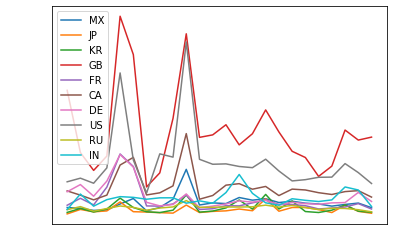

In [8]:
d3=myDF[['publish_time','likes','loc']]
# "2017-11-10T17:00:03.000Z"

d3=d3.withColumn('publish_time',f.col('publish_time').cast(TimestampType()))\
    .withColumn('hour',f.hour('publish_time'))

mean3 = d3.groupby(['hour','loc']).agg(f.mean("likes").alias('likes'))\
    .groupby('loc').agg(f.collect_list(f.struct(f.col('hour'),f.col("likes"))).alias("xy"))\
    .sort(f.col('xy.hour')).collect()   #this order not work .


for x in mean3:
    inOrder=sorted(x['xy'], key=lambda x:x['hour'])
    plt.plot(*zip(*inOrder))

plt.tick_params(axis='both', colors='white')
plt.legend([x['loc'] for x in mean3])
plt.show()

4: 排序出最多人不喜歡的前十名種類影片

In [9]:
d4=myDF.select('title','category_id','dislikes','snippet')

#前十名  的 影片種類
d4_tmp1=d4.sort(f.col('dislikes').desc()).head(10)

#前十名種類  (每種取平均)
d4_tmp2=d4.groupby(['snippet.title']).agg(f.mean('dislikes').alias('dislikes'))\
    .sort(f.col('dislikes').desc()).head(10)

display(d4_tmp1)
display(d4_tmp2)

[Row(title='Rae Sremmurd, Swae Lee, Slim Jxmmi - Powerglide ft. Juicy J', category_id='10', dislikes='9997', snippet=Row(assignable=True, channelId='UCBR8-60-B28hp2BmDPdntcQ', title='Music')),
 Row(title='Ядовитый газ развеял иллюзии: гарант ничего не гарантирует', category_id='25', dislikes='9995', snippet=Row(assignable=True, channelId='UCBR8-60-B28hp2BmDPdntcQ', title='News & Politics')),
 Row(title='The Logan Paul Odyssey', category_id='24', dislikes='9994', snippet=Row(assignable=True, channelId='UCBR8-60-B28hp2BmDPdntcQ', title='Entertainment')),
 Row(title='The Logan Paul Odyssey', category_id='24', dislikes='9994', snippet=Row(assignable=True, channelId='UCBR8-60-B28hp2BmDPdntcQ', title='Entertainment')),
 Row(title='Liam Payne - Bedroom Floor (Official Video)', category_id='10', dislikes='9993', snippet=Row(assignable=True, channelId='UCBR8-60-B28hp2BmDPdntcQ', title='Music')),
 Row(title='What Even Matters Anymore - SNL', category_id='24', dislikes='9993', snippet=Row(assigna

[Row(title='Nonprofits & Activism', dislikes=58076.85964912281),
 Row(title='Music', dislikes=6930.84205202992),
 Row(title='Entertainment', dislikes=2277.584188026347),
 Row(title='Gaming', dislikes=1698.936684640807),
 Row(title='Comedy', dislikes=1509.022358175751),
 Row(title='Science & Technology', dislikes=1495.3584628564436),
 Row(title='Movies', dislikes=1395.611111111111),
 Row(title='Film & Animation', dislikes=1207.7397162104057),
 Row(title='Sports', dislikes=1120.4199037324777),
 Row(title='People & Blogs', dislikes=1047.7688707170873)]

5: 排序出前十名的類別  喜歡 和 不喜歡的比例 擁有最大的變異數

In [10]:
d5=myDF[['title','category_id','dislikes','likes','snippet']]
d5= d5.withColumn("ratio"
                  ,f.col("likes")/(f.col("likes")+f.col("dislikes")))

d5_tmp1=d5.groupby('snippet.title')\
    .agg(f.variance("ratio").alias("ratio"))\
    .sort(f.col('ratio').desc())

display(d5_tmp1.head(10))

[Row(title='News & Politics', ratio=0.027392936222233745),
 Row(title='People & Blogs', ratio=0.02026205581933234),
 Row(title='Shows', ratio=0.015936979824433494),
 Row(title='Entertainment', ratio=0.013474663136959447),
 Row(title='Sports', ratio=0.01175676869434956),
 Row(title='Travel & Events', ratio=0.009779487343909347),
 Row(title='Film & Animation', ratio=0.009694414186666037),
 Row(title='Autos & Vehicles', ratio=0.009460250963378611),
 Row(title='Gaming', ratio=0.00868312800598222),
 Row(title='Education', ratio=0.007204956309669795)]